In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pmd
from statsmodels.tsa.api import DynamicFactorMQ
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [35]:
# Load the dataset
df = pd.read_csv("./BTC.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df['Vol.'] = df['Vol.'].str.replace('K', 'e3')
df['Vol.'] = df['Vol.'].str.replace('M', 'e6')
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
df

,Price,Vol.
Date,,
2017-12-01,10861.5,131920.0
2017-12-02,10912.7,86830.0
2017-12-03,11246.2,122130.0
2017-12-04,11623.9,93170.0
2017-12-05,11667.1,89690.0
...,...,...
2023-06-12,25906.8,40750.0
2023-06-13,25929.4,56240.0
2023-06-14,25129.5,60820.0


### 2. Split the data into training, test and validate sets

In [36]:
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1214, 2)
Test shape: (607, 2)
Validate shape: (203, 2)


In [37]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1416, 2)
Test shape: (404, 2)
Validate shape: (204, 2)


In [38]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1214, 2)
Test shape: (404, 2)
Validate shape: (406, 2)


## 3. Perform Dynamic Factor Model

### 3.1 Build and fit train data into Dynamic Factor Model

In [39]:
features = ['Price']
df_model = DynamicFactorMQ(endog=train_data, factors=2, factor_orders=1, idiosyncratic_ar1=True)
df_model_fit = df_model.fit(maxiter=100, disp=True)
df_model_fit.summary()

EM start iterations, llf=-2921.4
EM iteration 2, llf=-1614.7, convergence criterion=0.57612
EM terminated at iteration 2, llf=-1614.7, convergence criterion=0.57612 (while specified tolerance was 1e-06)


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:2648: UserWarning: Log-likelihood decreased at EM iteration 3. Reverting to the results from EM iteration 2 (prior to the decrease) and returning the solution.
  warn(f'Log-likelihood decreased at EM iteration {i + 1}.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Dynamic Factor Results                              
===================================================================================
Dep. Variable:           ['Price', 'Vol.']   No. Observations:                 1214
Model:                Dynamic Factor Model   Log Likelihood               -1649.558
                   + 2 factors in 2 blocks   AIC                           3323.116
                     + AR(1) idiosyncratic   BIC                           3384.336
Date:                     Fri, 16 Jun 2023   HQIC                          3346.164
Time:                             23:46:22   EM Iterations                        2
Sample:                         12-01-2017                                         
                              - 03-28-2021                                         
Covariance Type:              Not computed                                         
                          Observation equation:                           
==========================================================================
Factor loadings:          0          1    idiosyncratic: AR(1)        var.
--------------------------------------------------------------------------
           Price      -0.71       0.45                   -0.00        0.00
            Vol.       0.71       0.45                   -0.00        0.00
       Transition: Factor block 0      
=======================================
                 L1.0    error variance
---------------------------------------
         0       0.90              0.23
       Transition: Factor block 1      
=======================================
                 L1.1    error variance
---------------------------------------
         1       0.86              0.55
=======================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [40]:
def evaluate_dynamic_factor_model(data):
    pred = df_model_fit.predict(start=data.index[0], end=data.index[len(data)-1])
    data = data[features]
    pred = pred[features]
    mse = mean_squared_error(data, pred)
    mae = mean_absolute_error(data, pred)
    mape = mean_absolute_percentage_error(data, pred)
    rmse = mean_squared_error(data, pred, squared=False)
    return pred, mse, mae, mape, rmse

### 3.2 Evaluate on Validate data

In [41]:
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaluate_dynamic_factor_model(val_data)

print("Price predict on validate data:", y_pred_val)

Price predict on validate data:                    Price
2022-05-07  11432.605848
2022-05-08  11432.605848
2022-05-09  11432.605848
2022-05-10  11432.605848
2022-05-11  11432.605848
...                  ...
2023-06-12  11432.605848
2023-06-13  11432.605848
2023-06-14  11432.605848
2023-06-15  11432.605848
2023-06-16  11432.605848

[406 rows x 1 columns]


### 3.3 Evaluate on Test data

In [42]:
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaluate_dynamic_factor_model(test_data)
print("Price predict on test data:", y_pred_test)

Price predict on test data:                    Price
2021-03-29  50457.327080
2021-03-30  45807.122046
2021-03-31  41730.271477
2021-04-01  38153.753882
2021-04-02  35014.120182
...                  ...
2022-05-02  11432.605848
2022-05-03  11432.605848
2022-05-04  11432.605848
2022-05-05  11432.605848
2022-05-06  11432.605848

[404 rows x 1 columns]


### 3.4 Predict price for the next 30 days

In [43]:
last_index = len(df)

date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')

y_next_30_days = df_model_fit.predict(start=date_range[0], end=date_range[len(date_range)-1])[features]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
                   Price
2023-06-16  11432.605848
2023-06-17  11432.605848
2023-06-18  11432.605848
2023-06-19  11432.605848
2023-06-20  11432.605848
2023-06-21  11432.605848
2023-06-22  11432.605848
2023-06-23  11432.605848
2023-06-24  11432.605848
2023-06-25  11432.605848
2023-06-26  11432.605848
2023-06-27  11432.605848
2023-06-28  11432.605848
2023-06-29  11432.605848
2023-06-30  11432.605848
2023-07-01  11432.605848
2023-07-02  11432.605848
2023-07-03  11432.605848
2023-07-04  11432.605848
2023-07-05  11432.605848
2023-07-06  11432.605848
2023-07-07  11432.605848
2023-07-08  11432.605848
2023-07-09  11432.605848
2023-07-10  11432.605848
2023-07-11  11432.605848
2023-07-12  11432.605848
2023-07-13  11432.605848
2023-07-14  11432.605848
2023-07-15  11432.605848


### 4.  Evaluate accuracy validate, test data

In [44]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

                   MSE           MAE      MAPE          RMSE
Validate  1.507023e+08  11469.858191  0.482355  12276.087685
Test      1.213646e+09  33744.945164  0.727981  34837.422465


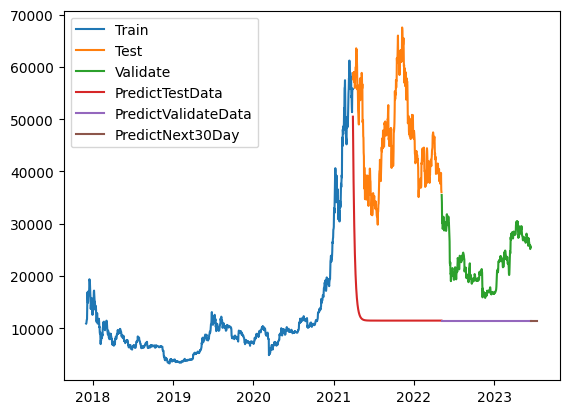

In [45]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()